#  Diabetes Prediction

## Contents
1. [Imports](#Imports)
2. [Loading the Dataset](#Loading-the-Dataset)
3. [DataProcessor Class](#DataProcessor-Class)
4. [MLPModel Class](#MLPModel-Class)
5. [End-to-End Pipeline](#End-to-End-Pipeline)
6. [Training and Evaluation](#Training-and-Evaluation)

In [90]:
pip install torch torchvision torchmetrics scikit-learn


## 1. Imports

In [91]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import random
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix
)
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, precision_score, recall_score, roc_auc_score,
                             roc_curve, auc)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics import Accuracy, Precision, Recall, AUROC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# For reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

print(f"Using TensorFlow version: {tf.__version__}")

Using TensorFlow version: 2.17.1


## 2. Loading the Dataset

In [92]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("iammustafatz/diabetes-prediction-dataset")

print("Path to dataset files:", path)
df = pd.read_csv(path + '/diabetes_prediction_dataset.csv')
df.head()

male_df = df[df['gender'] == "Male"]
female_df = df[df['gender'] == "Female"]
datasets = [male_df,female_df]

Path to dataset files: /root/.cache/kagglehub/datasets/iammustafatz/diabetes-prediction-dataset/versions/1


## 3. DataProcessor Class

In [93]:
class DataProcessor:
    """
    A refactored DataProcessor that:
    1. Drops duplicates.
    2. Drops rows missing target.
    3. Separates out numeric vs. categorical features.
    4. One-hot-encodes categorical features.
    5. Scales numeric columns only.
    """
    def __init__(self, df, target_col="diabetes", cat_cols=None):
        self.df = df.copy()
        self.target_col = target_col
        self.cat_cols = cat_cols

        self.numeric_cols = None
        self.encoded_cat_cols = None
        self.ohe = None  # OneHotEncoder for categorical
        self.scaler = None  # StandardScaler for numeric

        # Outputs
        self.features = None
        self.labels = None

    def preprocess(self):
        # 1. Drop duplicates
        init_rows = len(self.df)
        self.df.drop_duplicates(inplace=True)

        # 2. Drop rows missing target
        self.df.dropna(subset=[self.target_col], inplace=True)

        # 3. Separate out the labels
        self.labels = self.df[self.target_col].values
        self.df.drop(columns=[self.target_col], inplace=True)

        # 4. Categorical & numeric splits
        cat_df = self.df[self.cat_cols].copy()
        numeric_df = self.df.drop(columns=self.cat_cols).copy()

        # Save numeric_cols
        self.numeric_cols = numeric_df.columns.tolist()

        # Check missing values in cat cols
        print("Missing in categorical cols before encoding:\n", cat_df.isnull().sum())

        # 4a. One-hot encode cat
        self.ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        encoded_cat = self.ohe.fit_transform(cat_df)
        self.encoded_cat_cols = self.ohe.get_feature_names_out(self.cat_cols)
        cat_encoded_df = pd.DataFrame(encoded_cat, columns=self.encoded_cat_cols, index=cat_df.index)

        # Merge back
        self.df = pd.concat([numeric_df, cat_encoded_df], axis=1)

        # Self.features = numeric + cat-encoded
        self.features = self.df.values

        print(f"Preprocessing Complete. Rows changed from {init_rows} to {len(self.df)}.")

    def split_data(self, test_size=0.2, random_state=42):
        X_train, X_test, y_train, y_test = train_test_split(
            self.features, self.labels,
            test_size=test_size,
            random_state=random_state,
            stratify=self.labels
        )
        return X_train, X_test, y_train, y_test

    def fit_scaler(self, X_train):
        # We only fit on numeric columns
        numeric_data = X_train[:, :len(self.numeric_cols)]  # numeric are first columns
        self.scaler = StandardScaler()
        self.scaler.fit(numeric_data)
        print("Scaler fitted on numeric columns only.")

    def transform(self, X):
        if self.scaler is None:
            raise ValueError("Scaler not fit yet.")
        # Transform only numeric part
        numeric_data = X[:, :len(self.numeric_cols)]
        cat_data = X[:, len(self.numeric_cols):]

        numeric_scaled = self.scaler.transform(numeric_data)
        # combine scaled numeric & cat (unchanged)
        return np.concatenate([numeric_scaled, cat_data], axis=1)


## 4. MLPModel Class

In [94]:
class MLPModel(nn.Module):
    def __init__(self, input_dim, hidden_units=[128, 64], dropout_rate=0.5, l2_reg=1e-3):
        """
        Initializes the MLPModel.

        Args:
            input_dim (int): Number of input features.
            hidden_units (list): List containing the number of units in each hidden layer.
            dropout_rate (float): Dropout rate for regularization.
            l2_reg (float): L2 regularization factor.
        """
        super(MLPModel, self).__init__()
        self.input_dim = input_dim
        self.hidden_units = hidden_units
        self.dropout_rate = dropout_rate
        self.l2_reg = l2_reg

        # Define layers
        self.layers = nn.ModuleList()
        prev_units = input_dim

        for idx, units in enumerate(hidden_units):
            self.layers.append(nn.Linear(prev_units, units))
            self.layers.append(nn.BatchNorm1d(units))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(dropout_rate))
            prev_units = units

        # Output layer
        self.output_layer = nn.Linear(prev_units, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        """
        Forward pass of the model.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output probabilities.
        """
        for layer in self.layers:
            x = layer(x)
        x = self.output_layer(x)
        x = self.sigmoid(x)
        return x

class Trainer:
    def __init__(self, model, device, lr=1e-3, batch_size=128, patience=8, threshold=0.5):
        """
        Initializes the Trainer.

        Args:
            model (nn.Module): The PyTorch model to train.
            device (torch.device): Device to run the training on.
            lr (float): Learning rate.
            batch_size (int): Batch size for training.
            patience (int): Patience for early stopping.
            threshold (float): Decision threshold for binary classification.
        """
        self.model = model.to(device)
        self.device = device
        self.lr = lr
        self.batch_size = batch_size
        self.patience = patience
        self.threshold = threshold  # Added threshold parameter

        # Define loss function
        self.criterion = nn.BCELoss()

        # Define optimizer with L2 regularization
        self.optimizer = Adam(self.model.parameters(), lr=self.lr, weight_decay=self.model.l2_reg)

        # Learning rate scheduler
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=0.5, patience=3, verbose=True)

        # Metrics with specified task
        self.accuracy = Accuracy(task='binary').to(device)
        self.precision = Precision(task='binary').to(device)
        self.recall = Recall(task='binary').to(device)
        self.auroc = AUROC(task='binary').to(device)

    def set_threshold(self, new_threshold):
        """
        Updates the decision threshold.

        Args:
            new_threshold (float): New threshold value between 0 and 1.
        """
        if 0.0 < new_threshold < 1.0:
            self.threshold = new_threshold
            print(f"Decision threshold updated to {self.threshold}")
        else:
            raise ValueError("Threshold must be between 0 and 1.")

    def train(self, X_train, y_train, X_val, y_val, epochs=50, verbose=True):
        """
        Trains the model.

        Args:
            X_train (np.ndarray): Training features.
            y_train (np.ndarray): Training labels.
            X_val (np.ndarray): Validation features.
            y_val (np.ndarray): Validation labels.
            epochs (int): Maximum number of epochs.
            verbose (bool): Whether to print progress.

        Returns:
            dict: History of training and validation loss and metrics.
        """
            # Prepare data loaders
        train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
        val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))

        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)

        history = {
            'train_loss': [],
            'val_loss': [],
            'train_accuracy': [],
            'val_accuracy': [],
            'train_precision': [],
            'val_precision': [],
            'train_recall': [],
            'val_recall': [],
            'train_auroc': [],
            'val_auroc': []
        }

        best_val_loss = float('inf')
        best_model_wts = copy.deepcopy(self.model.state_dict())
        epochs_no_improve = 0

        for epoch in range(1, epochs + 1):
            # Training phase
            self.model.train()
            train_loss = 0.0

            for X_batch, y_batch in train_loader:
                X_batch = X_batch.to(self.device)
                y_batch = y_batch.to(self.device).unsqueeze(1)

                self.optimizer.zero_grad()
                outputs = self.model(X_batch)
                loss = self.criterion(outputs, y_batch)
                loss.backward()
                self.optimizer.step()

                train_loss += loss.item() * X_batch.size(0)

            train_loss /= len(train_loader.dataset)

            # Validation phase
            self.model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for X_batch, y_batch in val_loader:
                    X_batch = X_batch.to(self.device)
                    y_batch = y_batch.to(self.device).unsqueeze(1)

                    outputs = self.model(X_batch)
                    loss = self.criterion(outputs, y_batch)
                    val_loss += loss.item() * X_batch.size(0)

            val_loss /= len(val_loader.dataset)

            # Update metrics
            train_acc, train_prec, train_rec, train_auc = self.evaluate_metrics(train_loader)
            val_acc, val_prec, val_rec, val_auc = self.evaluate_metrics(val_loader)

            # Record history
            history['train_loss'].append(train_loss)
            history['val_loss'].append(val_loss)
            history['train_accuracy'].append(train_acc)
            history['val_accuracy'].append(val_acc)
            history['train_precision'].append(train_prec)
            history['val_precision'].append(val_prec)
            history['train_recall'].append(train_rec)
            history['val_recall'].append(val_rec)
            history['train_auroc'].append(train_auc)
            history['val_auroc'].append(val_auc)

            if verbose:
                print(f"Epoch {epoch}/{epochs} | "
                      f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
                      f"Val Accuracy: {val_acc:.4f} | Val Precision: {val_prec:.4f} | "
                      f"Val Recall: {val_rec:.4f} | Val AUROC: {val_auc:.4f}")

            # Scheduler step
            self.scheduler.step(val_loss)

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_wts = copy.deepcopy(self.model.state_dict())
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= self.patience:
                    if verbose:
                        print("Early stopping triggered.")
                    break

        # Load best model weights
        self.model.load_state_dict(best_model_wts)
        return history

    def evaluate_metrics(self, loader):
        """
        Evaluates metrics on a given data loader.

        Args:
            loader (DataLoader): DataLoader for evaluation.

        Returns:
            tuple: (accuracy, precision, recall, auroc)
        """
        self.model.eval()
        all_preds = []
        all_targets = []

        with torch.no_grad():
            for X_batch, y_batch in loader:
                X_batch = X_batch.to(self.device)
                y_batch = y_batch.to(self.device).unsqueeze(1)

                outputs = self.model(X_batch)
                all_preds.append(outputs)
                all_targets.append(y_batch)

        all_preds = torch.cat(all_preds)
        all_targets = torch.cat(all_targets)

        preds_binary = (all_preds >= self.threshold).float()  # Use instance threshold

        acc = self.accuracy(preds_binary, all_targets).item()
        prec = self.precision(preds_binary, all_targets).item()
        rec = self.recall(preds_binary, all_targets).item()
        auc = self.auroc(all_preds, all_targets).item()

        return acc, prec, rec, auc

    def evaluate(self, X_test, y_test):
        """
        Evaluates the model on the test set.

        Args:
            X_test (np.ndarray): Test features.
            y_test (np.ndarray): Test labels.

        Returns:
            dict: Test loss and metrics.
            np.ndarray: Predicted labels.
        """
        test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                                     torch.tensor(y_test, dtype=torch.float32))
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)

        self.model.eval()
        test_loss = 0.0
        all_preds = []
        all_targets = []

        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch = X_batch.to(self.device)
                y_batch = y_batch.to(self.device).unsqueeze(1)

                outputs = self.model(X_batch)
                loss = self.criterion(outputs, y_batch)
                test_loss += loss.item() * X_batch.size(0)

                all_preds.append(outputs)
                all_targets.append(y_batch)

        test_loss /= len(test_loader.dataset)
        all_preds = torch.cat(all_preds)
        all_targets = torch.cat(all_targets)

        preds_binary = (all_preds >= 0.5).float()

        acc = self.accuracy(preds_binary, all_targets).item()
        prec = self.precision(preds_binary, all_targets).item()
        rec = self.recall(preds_binary, all_targets).item()
        auc = self.auroc(all_preds, all_targets).item()

        # Convert tensors to numpy arrays
        y_true = all_targets.cpu().numpy().ravel()
        y_pred = preds_binary.cpu().numpy().ravel()

        return {
            'test_loss': test_loss,
            'test_accuracy': acc,
            'test_precision': prec,
            'test_recall': rec,
            'test_auroc': auc
        }, y_true, y_pred

    def predict(self, X, threshold=None):
        """
        Generates predictions for the input data.

        Args:
            X (np.ndarray): Input features.
            threshold (float, optional): Threshold for converting probabilities to binary predictions.
                                         If None, uses the instance's threshold.

        Returns:
            np.ndarray: Binary predictions.
        """
        self.model.eval()
        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
        with torch.no_grad():
            probs = self.model(X_tensor).cpu().numpy().ravel()
        effective_threshold = self.threshold if threshold is None else threshold
        return (probs > effective_threshold).astype(int)

## 5. End-to-End Pipeline
We'll demonstrate the usage of `DataProcessor` and `MLPModel`.

In [95]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTENC

def process_dataset(
    df: pd.DataFrame,
    target_col: str,
    cat_cols: list,
    smote: bool = False,
    test_size: float = 0.2,
    val_size: float = 0.2,
    random_state: int = 42
):
    # Initialize the DataProcessor
    processor = DataProcessor(df, target_col=target_col, cat_cols=cat_cols)
    processor.preprocess()

    # 1. Split data into train_val and test
    X_trainval_raw, X_test_raw, y_trainval, y_test = processor.split_data(
        test_size=test_size, random_state=random_state
    )

    # 2. Further split train_val into train and validation
    X_train_raw, X_val_raw, y_train, y_val = train_test_split(
        X_trainval_raw, y_trainval,
        test_size=val_size,
        random_state=random_state,
        stratify=y_trainval
    )

    # 3. Fit scaler on training data only (numeric cols)
    processor.fit_scaler(X_train_raw)

    # 4. Transform all splits
    X_train = processor.transform(X_train_raw)
    X_val = processor.transform(X_val_raw)
    X_test = processor.transform(X_test_raw)

    # 5. Define encoded_columns and identify their indices for SMOTENC
    encoded_columns = processor.encoded_cat_cols.tolist()
    numeric_len = len(processor.numeric_cols)
    encoded_len = len(encoded_columns)
    categorical_feature_indices = list(range(numeric_len, numeric_len + encoded_len))
    print(f"Categorical feature indices for SMOTENC: {categorical_feature_indices}")

    if smote:
        # 6. Initialize SMOTENC with static configuration
        smote_nc = SMOTENC(
            categorical_features=categorical_feature_indices,
            sampling_strategy='auto',  # You can adjust this as needed
            random_state=random_state
        )

        # 7. Apply SMOTENC to the training data
        X_train_res, y_train_res = smote_nc.fit_resample(X_train, y_train)

        # 8. Display class distribution before and after SMOTENC
        print("Class Distribution Before SMOTE:")
        print(pd.Series(y_train).value_counts())
        print("\nClass Distribution After SMOTENC:")
        print(pd.Series(y_train_res).value_counts())
    else:
        # If SMOTE is not applied, return the original training data
        X_train_res, y_train_res = X_train, y_train
        print("SMOTENC not applied. Returning original training data.")
        print("Class Distribution:")
        print(pd.Series(y_train).value_counts())

    return X_train_res, y_train_res, X_val, y_val, X_test, y_test, processor

## 6. Training and Evaluation

In [96]:
target_column = 'diabetes'
categorical_columns = ["gender", "smoking_history"]
def plot_history(history, evaluation):
    """
    Plots training and validation loss and metrics over epochs.

    Args:
        history (dict): Dictionary containing training history with keys:
                        'train_loss', 'val_loss',
                        'train_accuracy', 'val_accuracy',
                        'train_precision', 'val_precision',
                        'train_recall', 'val_recall',
                        'train_auroc', 'val_auroc'.
    """
    print("\nTest Evaluation:")
    print(f"Loss: {evaluation['test_loss']:.4f}")
    print(f"Accuracy: {evaluation['test_accuracy']:.4f}")
    print(f"Precision: {evaluation['test_precision']:.4f}")
    print(f"Recall: {evaluation['test_recall']:.4f}")
    print(f"AUC: {evaluation['test_auroc']:.4f}")
    print("\n")
    epochs = range(1, len(history['train_loss']) + 1)

    # Create subplots
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    # Plot Loss
    axs[0, 0].plot(epochs, history['train_loss'], label='Train Loss', color='blue')
    axs[0, 0].plot(epochs, history['val_loss'], label='Validation Loss', color='orange')
    axs[0, 0].set_title('Training and Validation Loss')
    axs[0, 0].set_xlabel('Epochs')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].legend()
    axs[0, 0].grid(True)

    # Plot Accuracy
    axs[0, 1].plot(epochs, history['train_accuracy'], label='Train Accuracy', color='green')
    axs[0, 1].plot(epochs, history['val_accuracy'], label='Validation Accuracy', color='red')
    axs[0, 1].set_title('Training and Validation Accuracy')
    axs[0, 1].set_xlabel('Epochs')
    axs[0, 1].set_ylabel('Accuracy')
    axs[0, 1].legend()
    axs[0, 1].grid(True)

    # Plot Precision and Recall
    axs[1, 0].plot(epochs, history['train_precision'], label='Train Precision', color='purple')
    axs[1, 0].plot(epochs, history['val_precision'], label='Validation Precision', color='pink')
    axs[1, 0].plot(epochs, history['train_recall'], label='Train Recall', color='brown')
    axs[1, 0].plot(epochs, history['val_recall'], label='Validation Recall', color='gray')
    axs[1, 0].set_title('Training and Validation Precision & Recall')
    axs[1, 0].set_xlabel('Epochs')
    axs[1, 0].set_ylabel('Score')
    axs[1, 0].legend()
    axs[1, 0].grid(True)

    # Plot AUROC
    axs[1, 1].plot(epochs, history['train_auroc'], label='Train AUROC', color='cyan')
    axs[1, 1].plot(epochs, history['val_auroc'], label='Validation AUROC', color='magenta')
    axs[1, 1].set_title('Training and Validation AUROC')
    axs[1, 1].set_xlabel('Epochs')
    axs[1, 1].set_ylabel('AUROC')
    axs[1, 1].legend()
    axs[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes=['Negative', 'Positive'], title='Confusion Matrix'):
    """
    Plots the confusion matrix.

    Args:
        y_true (np.ndarray): True labels.
        y_pred (np.ndarray): Predicted labels.
        classes (list): List of class names.
        title (str): Title of the plot.
    """
    cm = confusion_matrix(y_true, y_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

    plt.figure(figsize=(6, 5))
    cm_display.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title(title)
    plt.show()

======== Training and eval ======
Missing in categorical cols before encoding:
 gender             0
smoking_history    0
dtype: int64
Preprocessing Complete. Rows changed from 100000 to 96146.
Scaler fitted on numeric columns only.
Categorical feature indices for SMOTENC: [6, 7, 8, 9, 10, 11, 12, 13, 14]
SMOTENC not applied. Returning original training data.
Class Distribution:
0    56103
1     5429
Name: count, dtype: int64
Epoch 1/50 | Train Loss: 0.2467 | Val Loss: 0.1384 | Val Accuracy: 0.9533 | Val Precision: 0.7638 | Val Recall: 0.6817 | Val AUROC: 0.9574
Epoch 2/50 | Train Loss: 0.1485 | Val Loss: 0.1235 | Val Accuracy: 0.9574 | Val Precision: 0.8610 | Val Recall: 0.6161 | Val AUROC: 0.9602
Epoch 3/50 | Train Loss: 0.1369 | Val Loss: 0.1141 | Val Accuracy: 0.9609 | Val Precision: 0.8946 | Val Recall: 0.6315 | Val AUROC: 0.9663
Epoch 4/50 | Train Loss: 0.1286 | Val Loss: 0.1098 | Val Accuracy: 0.9626 | Val Precision: 0.9353 | Val Recall: 0.6183 | Val AUROC: 0.9678
Epoch 5/50 | T

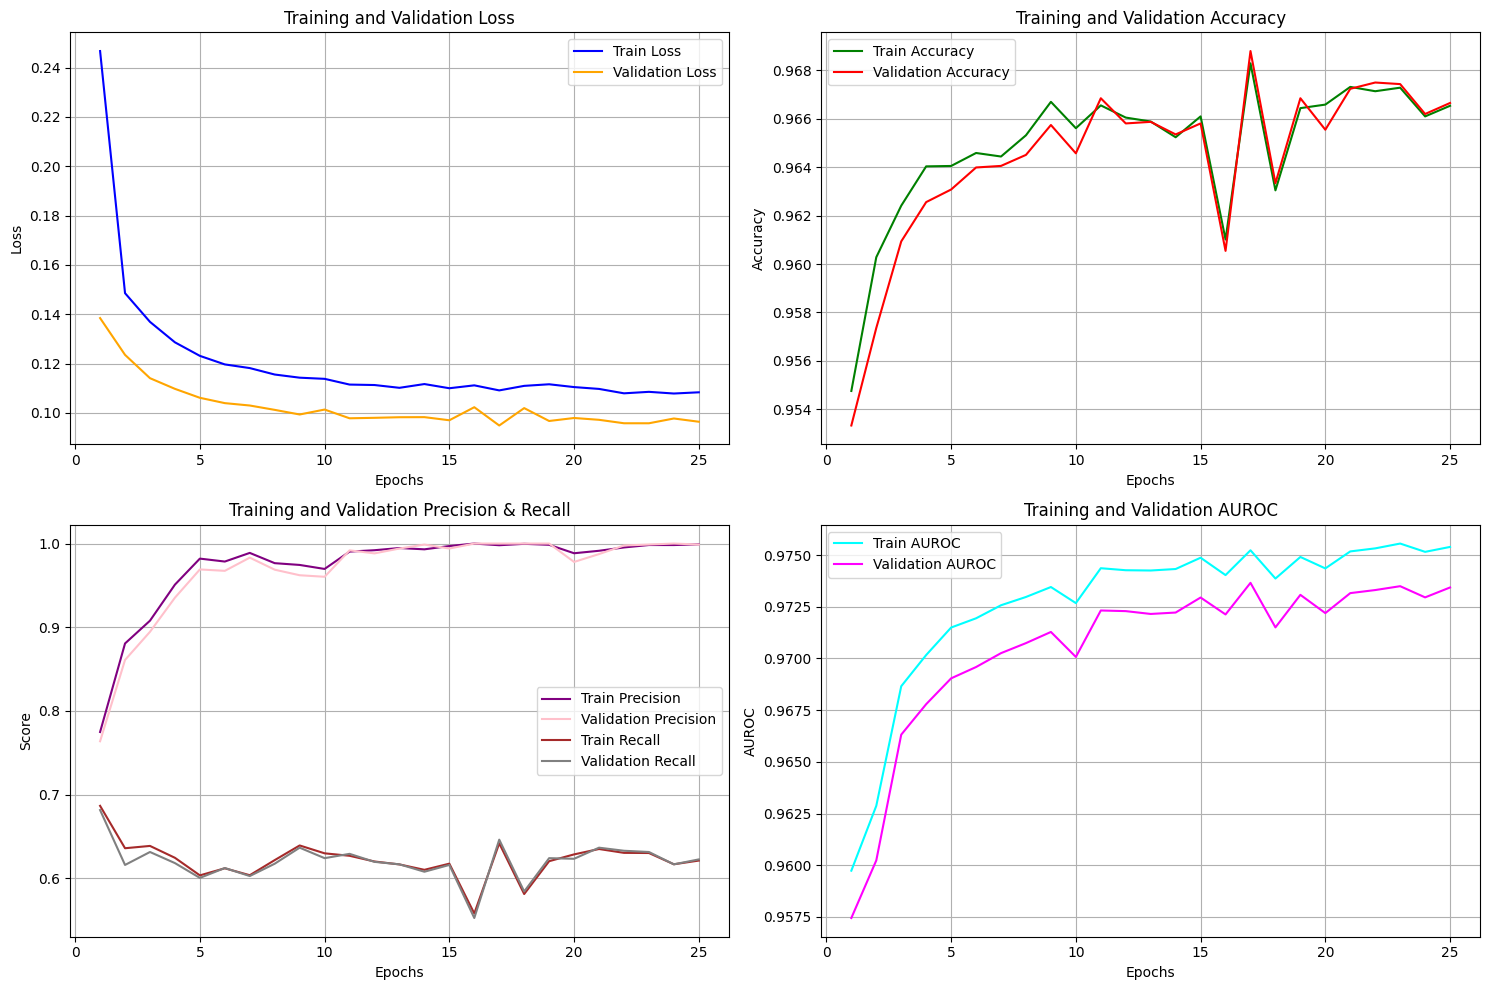

<Figure size 600x500 with 0 Axes>

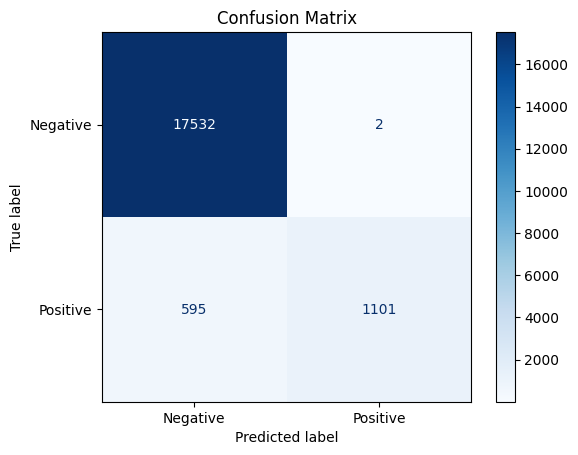

In [101]:
print("======== Training and eval ======")

X_train, y_train, X_val, y_val, X_test, y_test, data_processor = process_dataset(
    df=df,
    target_col=target_column,
    cat_cols=categorical_columns,
    smote=False,
    test_size=0.2,
    val_size=0.2,
    random_state=42
)
# Initialize the model
model = MLPModel(input_dim = X_train.shape[1], hidden_units=[64, 32], dropout_rate=0.5, l2_reg=1e-3)

# Initialize the trainer
trainer = Trainer(model=model, device=device, lr=1e-3, batch_size=128, patience=8)

# Train the model
history = trainer.train(X_train, y_train, X_val, y_val, epochs=50, verbose=True)

# Evaluate the model
evaluation, y_true, y_pred = trainer.evaluate(X_test, y_test)
plot_history(history, evaluation)
plot_confusion_matrix(y_true, y_pred)

======== Training and eval (SMOTE) ======
Missing in categorical cols before encoding:
 gender             0
smoking_history    0
dtype: int64
Preprocessing Complete. Rows changed from 41430 to 39967.
Scaler fitted on numeric columns only.
Categorical feature indices for SMOTENC: [6, 7, 8, 9, 10, 11, 12]
Class Distribution Before SMOTE:
0    22996
1     2582
Name: count, dtype: int64

Class Distribution After SMOTENC:
0    22996
1    22996
Name: count, dtype: int64
Epoch 1/50 | Train Loss: 0.5706 | Val Loss: 0.3607 | Val Accuracy: 0.8635 | Val Precision: 0.4192 | Val Recall: 0.9118 | Val AUROC: 0.9604
Epoch 2/50 | Train Loss: 0.3893 | Val Loss: 0.2523 | Val Accuracy: 0.8979 | Val Precision: 0.4969 | Val Recall: 0.8824 | Val AUROC: 0.9634
Epoch 3/50 | Train Loss: 0.3500 | Val Loss: 0.2778 | Val Accuracy: 0.8686 | Val Precision: 0.4303 | Val Recall: 0.9272 | Val AUROC: 0.9640
Epoch 4/50 | Train Loss: 0.3372 | Val Loss: 0.2306 | Val Accuracy: 0.8835 | Val Precision: 0.4607 | Val Recall: 0

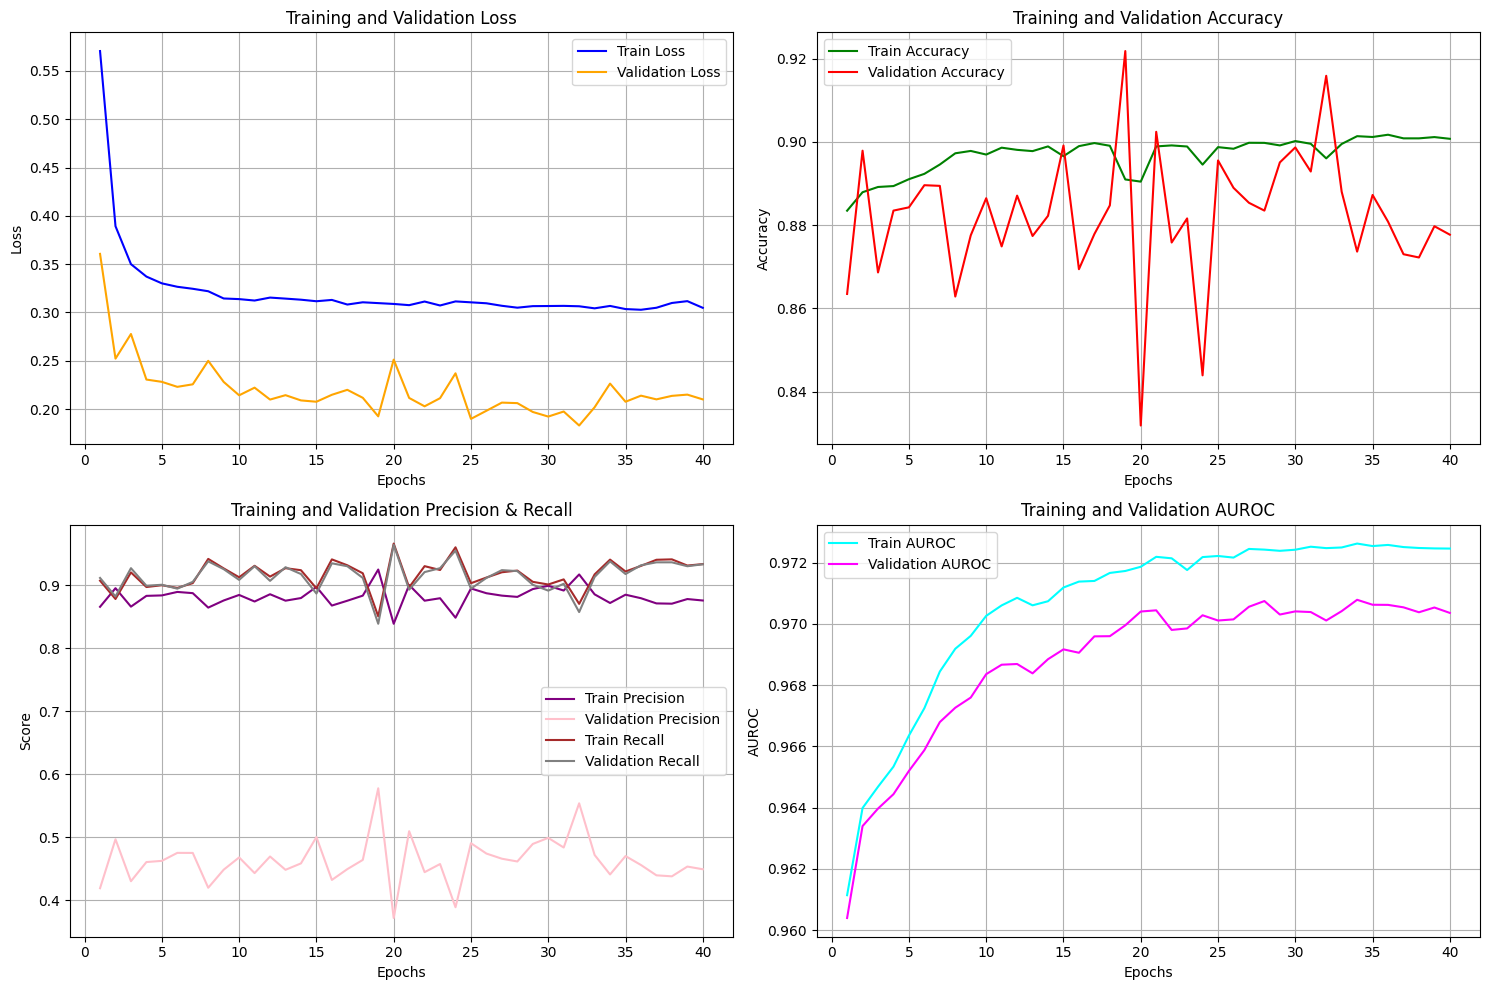

<Figure size 600x500 with 0 Axes>

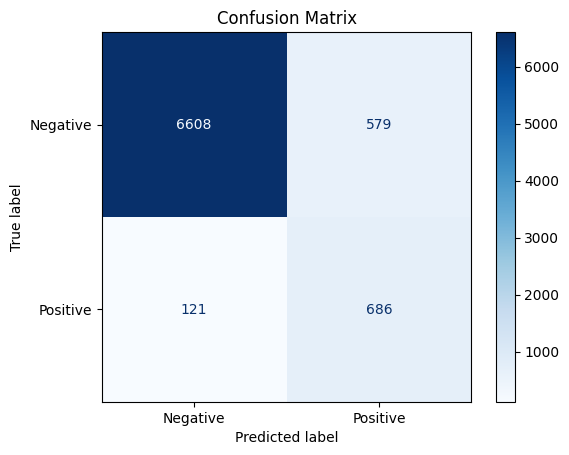

In [102]:
print("======== Training and eval (SMOTE) ======")
X_train, y_train, X_val, y_val, X_test, y_test, data_processor = process_dataset(
    df=male_df,
    target_col=target_column,
    cat_cols=categorical_columns,
    smote=True,  # Set to True to apply SMOTENC
    test_size=0.2,
    val_size=0.2,
    random_state=42
)
# Initialize the model
model = MLPModel(input_dim = X_train.shape[1], hidden_units=[16, 12, 8], dropout_rate=0.5, l2_reg=1e-3)

# Initialize the trainer
trainer = Trainer(model=model, device=device, lr=1e-3, batch_size=128, patience=8)

# Train the model
history = trainer.train(X_train, y_train, X_val, y_val, epochs=50, verbose=True)

# Evaluate the model
evaluation, y_true, y_pred = trainer.evaluate(X_test, y_test)
plot_history(history, evaluation)
plot_confusion_matrix(y_true, y_pred)